# Equivariant learning of tensorial properties: EFG tensors

This is a demonstration of equivariant of a tensorial property - EFG (or NMR
shielding) tensors using pre-calculated data expressed in the angular basis.

### Requirements

* python > 3.10

### Required packages

For stability, it is best to install `rascaline` and `rho_learn` from specific commits.

1. `pip install ase chemiscope metatensor torch==2.1.0 wigners`
1. `pip install git+https://github.com/luthaf/rascaline.git@b2cedfe870541e6d037357db58de1901eb116c41`
1. `pip install git+https://github.com/jwa7/rho_learn.git@9139fd560ff663236bc416621118fb0de9a36009`

In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import torch

# From the COSMO-stack
import metatensor   # storage format for atomistic ML
import chemiscope  # interactive molecular visualization
import rascaline   # generating structural representations
from metatensor import Labels, TensorBlock, TensorMap
from rascaline.utils import clebsch_gordan

# Torch-based equivariant leaning
from rholearn import io, data, loss, models
import settings

## Visualize structures in dataset

* Use `chemiscope`

In [2]:
from settings import TOP_DIR, DATA_DIR, ML_DIR, DATA_SETTINGS

print("Top directory defined as: ", TOP_DIR)

# Load the frames in the complete dataset
all_frames = DATA_SETTINGS["all_frames"]

# Shuffle the total set of structure indices
idxs = np.arange(len(all_frames))
np.random.default_rng(seed=DATA_SETTINGS["seed"]).shuffle(idxs)

# Take a subset of the frames if desired
idxs = idxs[:DATA_SETTINGS["n_frames"]]
frames = [all_frames[A] for A in idxs]

# Define a callable that returns the path of a dir containing the data
# for a single structure
def struct_dir(A):
    return os.path.join(DATA_DIR, f"{A}")

Top directory defined as:  /Users/joe.abbott/Documents/phd/code/rho/rho_learn/docs/example/tensor


In [3]:
chemiscope.show(
    frames,
    mode="structure",
)

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 42, "names": ["Li", "Li", "Li", "Li", "…

## Convert EFG tensors to metatensor format

In [4]:
# We will create a TensorMap for each frame, then combine them into a single
# TensorMap at the end
structure_tms = []
for A, frame in zip(idxs, frames):
    # Get the number of atoms in the frame
    n_atoms = frame.get_global_number_of_atoms()

    # Store the target data by l value and chemical species (i.e. atomic number)
    data_dict = {}
    for atom_i, atomic_number in enumerate(frame.get_atomic_numbers()):
        for l, data_arr_all_atoms in zip(
            [0, 2], [frames[0].arrays["efg_L0"], frames[0].arrays["efg_L2"]]
        ):
            key = (l, atomic_number)
            data_arr = data_arr_all_atoms[atom_i]
            if isinstance(data_arr, float):
                data_arr = np.array([data_arr])
            # Store the data array
            if data_dict.get(key) is None:
                data_dict[key] = {atom_i: data_arr}
            else:
                data_dict[key][atom_i] = data_arr

    # Build the keys of the resulting TensorMap
    keys = Labels(
        names=["spherical_harmonics_l", "species_center"],
        values=np.array(
            [[l, species_center] for l, species_center in data_dict.keys()]
        ),
    )

    # Construct the TensorMap blocks for each of these keys
    blocks = []
    for l, species_center in keys.values:
        # Retrive the raw block data
        data_block = data_dict[(l, species_center)]

        # Get a list of sorted samples (i.e. atom indices) for the block
        n_atoms_block = len(data_block)
        ordered_atom_idxs = sorted(data_block.keys())

        # Sort the raw block data
        block_data = np.array([data_block[atom_i] for atom_i in ordered_atom_idxs]).reshape(
            n_atoms_block, 2 * l + 1, 1
        )

        # Construct a TensorBlock, where the raw data is labelled with metadata
        # Note here that we keep track of the structure index - this is
        # important for later when we join the TensorMaps
        block = TensorBlock(
            values=block_data,
            samples=Labels(
                names=["structure", "center"],
                values=np.array([[A, atom_i] for atom_i in ordered_atom_idxs]),
            ),
            components=[
                Labels(
                    names=["spherical_harmonics_m"],
                    values=np.arange(-l, l + 1).reshape(-1, 1),
                )
            ],
            properties=Labels(
                names=["efg"],
                values=np.array([[0]]).reshape(-1, 1),
            ),
        )
        # Store the block
        blocks.append(block)

    # Construct a TensorMap for this structure from the keys and blocks
    efg = TensorMap(keys=keys, blocks=blocks)

    # Save the TensorMap to file
    if not os.path.exists(struct_dir(A)):
        os.mkdir(struct_dir(A))
    metatensor.save(os.path.join(struct_dir(A), "efg.npz"), efg)

## Build Structural Descriptors 

* Here we construct $\lambda$-SOAP equivariant descriptors for each structure

In [5]:
from settings import RASCAL_SETTINGS, CG_SETTINGS

# Generate a rascaline SphericalExpansion (2 body) representation. As we want to
# retain the original structure indices, we are going to pass * all * of the
# 1000 frames to rascaline, but only compute for the subset of structures in
# `idxs`.
calculator = rascaline.SphericalExpansion(**RASCAL_SETTINGS["hypers"])
nu_1_tensor = calculator.compute(
    all_frames, 
    selected_samples=Labels(names=["structure"], values=idxs.reshape(-1, 1)),
    **RASCAL_SETTINGS["compute"],
)
nu_1_tensor = nu_1_tensor.keys_to_properties("species_neighbor")

# Build a lambda-SOAP descriptor by a CLebsch-Gordan combination
lsoap = clebsch_gordan.lambda_soap_vector(nu_1_tensor, **CG_SETTINGS)

# Check the resulting structure indices match those in `idxs`
assert np.all(
    np.sort(idxs)
    == metatensor.unique_metadata(lsoap, "samples", "structure").values.reshape(-1)
)

# Split into per-structure TensorMaps and save into separate directories.
# This is useful for batched training.
for A in idxs:
    lsoap_A = metatensor.slice(
        lsoap,
        "samples",
        labels=Labels(names="structure", values=np.array([A]).reshape(-1, 1)),
    )
    metatensor.save(os.path.join(struct_dir(A), "lsoap.npz"), lsoap_A)

## Build `dataset`

* For cross-validation we create a train-test-val split of the data.
* Data is stored on the per-structure basis to help with mini-batching in
  training.


* Although we have generated data for both the HOMO and LUMO, let's just learn
  the HOMO. Fix the "restart_idx" to 0 (for the HOMO), then we can build a
  dataset and start training.

In [6]:
# Define dir where model checkpoints are saved
chkpt_dir = os.path.join(ML_DIR, "checkpoints")

if not os.path.exists(ML_DIR):
    os.makedirs(ML_DIR)
if not os.path.exists(chkpt_dir):
    os.makedirs(chkpt_dir)

In [7]:
from settings import CROSSVAL_SETTINGS, ML_SETTINGS, TORCH_SETTINGS

# Perform a train/test/val split of structure idxs
train_idxs, test_idxs, val_idxs = data.group_idxs(
    idxs=idxs,
    n_groups=CROSSVAL_SETTINGS["n_groups"],
    group_sizes=CROSSVAL_SETTINGS["group_sizes"],
    shuffle=CROSSVAL_SETTINGS["shuffle"],
    seed=DATA_SETTINGS["seed"],
)
print(
    "num train_idxs:",
    len(train_idxs),
    "   num test_idxs:",
    len(test_idxs),
    "   num val_idxs:",
    len(val_idxs),
)
np.savez(
    os.path.join(ML_DIR, "idxs.npz"),
    idxs=idxs,
    train_idxs=train_idxs,
    test_idxs=test_idxs,
    val_idxs=val_idxs,
)

num train_idxs: 18    num test_idxs: 6    num val_idxs: 6


In [8]:
# Construct dataset, defining callables to access the input, output, and overlap
# data from the structure indices
efg_data = data.RhoData(
    idxs=idxs,
    in_path=lambda A: os.path.join(struct_dir(A), "lsoap.npz"),
    out_path=lambda A: os.path.join(struct_dir(A), "efg.npz"),
    keep_in_mem=ML_SETTINGS["loading"]["train"]["keep_in_mem"],
    **TORCH_SETTINGS,
)

## Initialize model

* In order to make an end-to-end prediction, we want to store the settings
  needed to build the equivariant descriptor from ASE frames, and well as the
  'recipe' for doing so.

* In the module `predictor.py`, the function `descriptor_builder` contains this
  recipe, identical to the one shown above. The function takes as input the ASE
  frames and settings and builds the $\lambda$-SOAP equivariant. A prediction
  can then be made on this.

* By storing the settings in the model upon initialization, the
  `model.predict()` method can build descriptors using the same settings as used
  to generate the training data (required), by calling the `descriptor_builder`
  function.

* This is a convenience method, allowing an easy end-to-end prediction and
  hiding all of the intermediate steps. Be aware however that this is dependent
  on an external method (i.e. `descriptor_builder`) built into the source code:
  ideally, we would like the descriptor calculators themselves (not just the
  settings) to be savable as part of the model. 

* With the current implementation, there is a risk that the `descriptor_builder`
  function becomes obselete upon API changes - specifically with respect to the
  CG iteration code which is still in development.

* Of course, using the software versions from commit numbers as above will
  ensure things work, but this is worth being aware of.
  
* One can always extract the descriptor settings from a model (atribute
  `model.descriptor_kwargs`) and manually build a descriptor, as we did above,
  before calling the `model.forward()` method. If making a prediction this
  should be done within the `with torch.no_grad()` context manager or by setting
  the model to evaluation mode with `model.eval()`.

In [9]:
from settings import ML_SETTINGS

descriptor_kwargs = {
    "rascal_settings": RASCAL_SETTINGS,
    "cg_settings": CG_SETTINGS,
}

* Here we intialize a global model that makes predicitons on the TensorMap level

* For demo purposes we set each block model to be a linear model. A learnable
  bias is used for invariant blocks, but cannot be applied to covariant blocks
  ($\lambda > 0$) as this is a non-linear transformation that would break equivariance.

* One could also use nonlinear block models which incorporate nonlinear
  transformations of invariant features using neural networks of (in
  principle)arbitrary complexity.
  
* The `RhoModel` class is built to be able to use these different types of block
  models without breaking equivariance. For instance, covariant blocks cannot
  themselves be passed through neural networks (nonlinear transformations that
  woudl break equivariance), but passing the corresponding invariant block for
  that species and using that as a linear multiplier is possible. This is the
  method implemented in this class, inspired by paper
  https://doi.org/10.1063/1.5090481, in particular Figure 5.

* Upon initialization, an example input/output pair from the dataset is passed
  to the constructor. The relevant metadata for each block (i.e. the components
  and properties) is extracted. This is used to initialize the dimensions of the
  underlying pure torch models.
  torch models

In [10]:
# Initialize model
model = models.RhoModel(
    # Model architecture
    model_type=ML_SETTINGS["model"]["model_type"],  # "linear" or "nonlinear"
    input=efg_data[idxs[0]][1],   # example input data for init metadata
    output=efg_data[idxs[0]][2],  # example output data for init metadata
    bias_invariants=ML_SETTINGS["model"]["bias_invariants"],

    # Extra architecture settings if using a nonlinear base model
    # hidden_layer_widths=ML_SETTINGS["model"].get("hidden_layer_widths"),
    # activation_fn=ML_SETTINGS["model"].get("activation_fn"),
    # bias_nn=ML_SETTINGS["model"].get("bias_nn"),

    # For end-to-end predictions
    descriptor_kwargs=descriptor_kwargs,
    
    # Torch tensor settings
    **TORCH_SETTINGS
)

In [11]:
# Inspect the input metadata of the model - notice the components / properties
# are stored, but not the samples. No data is stored either (block values are
# just zero)
model.in_metadata.keys

Labels(
    spherical_harmonics_l  species_center
              0                  3
              2                  3
              0                  8
              2                  8
              0                  22
              2                  22
)

In [12]:
# Inspect the output metadata
model.out_metadata.block(0)

TensorBlock
    samples (1): ['_']
    components (1): ['spherical_harmonics_m']
    properties (1): ['efg']
    gradients: None

In [13]:
# Inspect the block models - these are stored as a torch ModuleList; one for
# each of the keys the model is defined for. For instance, the first block model
# corresponds to key `model.in_metadata.keys[0]`
model.models

ModuleList(
  (0): _LinearModel(
    (linear): Linear(in_features=1944, out_features=1, bias=True)
  )
  (1): _LinearModel(
    (linear): Linear(in_features=2916, out_features=1, bias=False)
  )
  (2): _LinearModel(
    (linear): Linear(in_features=1944, out_features=1, bias=True)
  )
  (3): _LinearModel(
    (linear): Linear(in_features=2916, out_features=1, bias=False)
  )
  (4): _LinearModel(
    (linear): Linear(in_features=1944, out_features=1, bias=True)
  )
  (5): _LinearModel(
    (linear): Linear(in_features=2916, out_features=1, bias=False)
  )
)

## Equivariance Check!

* Both the code that performs the transformations `.xyz` data -> equivariant descriptor (i.e. the
  $\lambda$-SOAP builder) and descriptor -> property (i.e. the model) should
  preserve equivariance.

* We can test this by performing an end-to-end prediction (i.e. `.xyz` ->
  descriptor -> property) for a rotated and unrotated form of the same
  structure, and checking that the predicted target property has transformed
  equivariantly with the input structure - i.e. the behaviour under rotation is
  described by a set of Wigner-D matrices for each angular order $\lambda$ the
  descriptor/model/target is decomposed into.

* A model should be equivariant regardless of the accuracy of the prediction.
  Therefore, we can test equivariance on a untrained model.

In [14]:
# Generate Wigner-D matrices, initialized with random angles
wig = clebsch_gordan.WignerDReal(lmax=2*RASCAL_SETTINGS["hypers"]["max_angular"])
print("Random rotation angles (rad):", wig.angles)

# Apply an O(3) transformation to each frame 
frames_o3 = [clebsch_gordan.transform_frame_o3(frame, wig.angles) for frame in frames]
assert not np.allclose(frames[0].positions, frames_o3[0].positions)

# Generate lambda-SOAP for the transformed frames
predictions = model.predict(structure_idxs=idxs, frames=frames)
predictions_o3 = model.predict(structure_idxs=idxs, frames=frames_o3)

# Iterate over structures
for pred, pred_o3 in zip(predictions, predictions_o3):

    # Apply the O(3) transformation to the TensorMap
    pred_transf = wig.transform_tensormap_o3(pred)

    # Check for equivariance!
    assert metatensor.equal_metadata(pred_transf, pred_o3)
    assert metatensor.allclose(pred_transf, pred_o3)
print("O(3) EQUIVARIANT!")

Random rotation angles (rad): [1.52917932 5.91039597 1.69280679]
O(3) EQUIVARIANT!


## Initialize training objects: loaders, loss, optimizer

In [15]:
# Construct dataloaders
train_loader = data.RhoLoader(
    efg_data,
    idxs=train_idxs,
    get_aux_data=False,
    batch_size=ML_SETTINGS["loading"]["train"]["batch_size"],
)
test_loader = data.RhoLoader(
    efg_data,
    idxs=test_idxs,
    get_aux_data=False,
    batch_size=ML_SETTINGS["loading"]["test"]["batch_size"],
)
val_loader = data.RhoLoader(
    efg_data,
    idxs=val_idxs,
    get_aux_data=False,
    batch_size=None,
)

In [16]:
# Initialize loss fxn and optimizer (don't use a scheduler for now)
loss_fn = loss.L2Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# A scheduler can be optionally used too
scheduler = None
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=10, factor=0.75
# )

## Run model training

* We train the model by gradient descent, evaluating an L2 loss of the prediction
  against the QM quantity.

  * $ \mathcal{L}_A^{\text{L2}} = \left( \textbf{c}_A^{\text{ML}} -\textbf{c}_A^{\text{EFG}} \right) ^2 $


In [17]:
from rholearn import train
from settings import ML_SETTINGS

# Define a log file for writing losses at each epoch
log_path = os.path.join(ML_DIR, "training.log")
io.log(log_path, "# epoch train_L2_loss test_L2_loss time")

if ML_SETTINGS["training"].get("restart_epoch") is not None:
    start_epoch = ML_SETTINGS["training"]["restart_epoch"]
    optimizer.load_state_dict(
        torch.load(os.path.join(chkpt_dir, f"optimizer_{start_epoch}.pt"))
    )
    # scheduler.load_state_dict(
    #     torch.load(os.path.join(chkpt_dir, f"scheduler_{start_epoch}.pt"))
    # )
    start_epoch += 1
else:
    start_epoch = 1

# Run training loop
for epoch in range(start_epoch, ML_SETTINGS["training"]["n_epochs"] + 1):
    # Training step
    t0 = time.time()
    train_loss_epoch, test_loss_epoch = train.training_step(
        train_loader=train_loader,
        test_loader=test_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        check_args=True
        if epoch == 1
        else False,  # Switch off metadata checks after 1st epoch
    )

    dt = time.time() - t0
    if scheduler is None:
        io.log(
            log_path,
            f"{epoch} {train_loss_epoch} {test_loss_epoch} {dt}",
        )
    else:
        io.log(
            log_path,
            f"{epoch} {train_loss_epoch} {test_loss_epoch} {dt} {scheduler._last_lr[0]}",
        )
    if epoch % ML_SETTINGS["training"]["save_interval"] == 0:
        torch.save(model, os.path.join(chkpt_dir, f"model_{epoch}.pt"))
        torch.save(optimizer.state_dict(), os.path.join(chkpt_dir, f"optimizer_{epoch}.pt"))
        # torch.save(scheduler.state_dict(), os.path.join(chkpt_dir, f"scheduler_{epoch}.pt"))

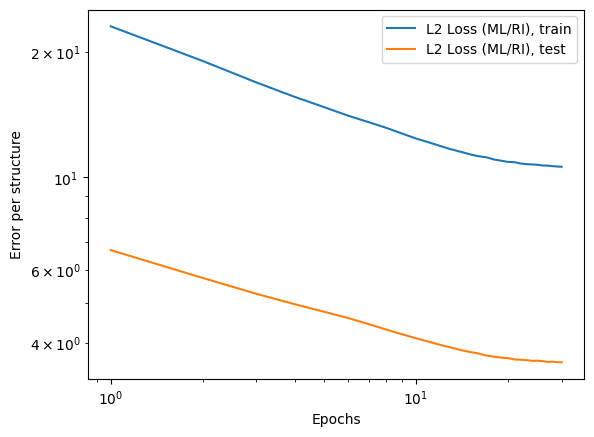

In [18]:
# Load training log
losses = np.loadtxt(os.path.join(ML_DIR, "training.log"))

# Plot the various errors
fig, ax = plt.subplots()

# Unpack data from each row
if scheduler is None:
    epochs, train_loss, test_loss, times = losses.T
else:
    epochs, train_loss, test_loss, times, lr = losses.T
    ax.plot(epochs, lr, label="learning rate")

ax.plot(epochs, train_loss, label="L2 Loss (ML/RI), train")
ax.plot(epochs, test_loss, label="L2 Loss (ML/RI), test")

# Format the plot
ax.set_xlabel("Epochs")
ax.set_ylabel("Error per structure")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

## End-to-end prediction on the validation set

* Now let's make an end-to-end prediction (from xyz -> target EFG tensors)
  on the validation set.

* We have already generated a descriptor for these frames, but for demonstrative
  purposes we will input the ASE frames to the `predict()` method.

* Returned is a list of predictions for each structure passed in `frames`.

* First, load a pre-trained model from file.

In [19]:
# Load pre-trained model
model = torch.load(os.path.join(chkpt_dir, "model_30.pt"))

In [20]:
val_frames = [all_frames[A] for A in val_idxs]
efg_pred_from_xyz = model.predict(structure_idxs=val_idxs, frames=val_frames)
efg_pred_from_xyz

[TensorMap with 6 blocks
 keys: spherical_harmonics_l  species_center
                 0                  3
                 2                  3
                       ...
                 0                  22
                 2                  22,
 TensorMap with 6 blocks
 keys: spherical_harmonics_l  species_center
                 0                  3
                 2                  3
                       ...
                 0                  22
                 2                  22,
 TensorMap with 6 blocks
 keys: spherical_harmonics_l  species_center
                 0                  3
                 2                  3
                       ...
                 0                  22
                 2                  22,
 TensorMap with 6 blocks
 keys: spherical_harmonics_l  species_center
                 0                  3
                 2                  3
                       ...
                 0                  22
                 2              

* As mentioned above, we could also just call the forward method, passing the
  TensorMap of descriptors instead of the ASE frames, but with gradient tracking
  switched off:

In [21]:
# Make a prediction on the pre-computed descriptors
with torch.no_grad():

    efg_pred_from_desc = []
    for A in val_idxs:
        _, in_val, out_val = efg_data[A]
        efg_pred_from_desc.append(model(in_val))

In [22]:
# Check the outputs give the same results
[
    metatensor.allclose(from_xyz, from_desc)
    for from_xyz, from_desc in zip(efg_pred_from_xyz, efg_pred_from_desc)
]

[True, True, True, True, True, True]